# Advanced Business Analytics Capstone

## Module 2 - Part 2 : Perform predictive analysis tasks (linear regression, regression tree, neural network)

In [1]:
#Import librairies
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

import pandas as pd

In [2]:
#Download file Lending_Club.csv
lclub = pd.read_csv("Lending_Club.csv", sep = ";")

'''
See Module 1 for complete cleaning and preparing procedure

'''

#Remove unnecessary columns
lclub = lclub.drop(columns=['id', 'member_id'])

#Fix incorrect data types for numerical columns ('int_rate', 'installment', 'annual_inc', 'total_pymnt', 'revol_util')
num_cols_to_fix = ['int_rate', 'installment', 'annual_inc', 'total_pymnt', 'revol_util']

for col in num_cols_to_fix:
    # Convert values to string for cleaning
    lclub[col] = lclub[col].astype(str)

    # Remove common non-numeric characters (% $ ,) and strip whitespace
    lclub[col] = (lclub[col]
                  .str.replace('%', '', regex=False)
                  .str.replace('$', '', regex=False)
                  .str.replace(',', '.', regex=False)
                  .str.strip())

    # Convert cleaned strings to numeric (float), coercing errors to NaN
    lclub[col] = pd.to_numeric(lclub[col], errors='coerce')

In [3]:
#Remove unnecessary columns
lclub = lclub.drop(columns=['term', 'purpose'])

# Filter to keep only the two target classes of interest, then binary encoding
lclub = lclub[lclub['loan_status'].isin(['Fully Paid', 'Charged Off'])]
lclub['loan_status'] = lclub['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

#Encode categorical variables using one-hot encoding (more than 2 categories)
cat_cols = ['home_ownership', 'verification_status']
lclub = pd.get_dummies(lclub, columns = cat_cols, drop_first = True)

In [4]:
#Manage missing values
lclub = lclub.dropna(subset=['revol_util'])

In [5]:
#Keep only loans with status 'Charged Off'
charged_off = lclub[lclub['loan_status'] == 1].copy()

#Convert all boolean columns to integers (0 and 1)
bool_cols = charged_off.select_dtypes(include='bool').columns
charged_off[bool_cols] = charged_off[bool_cols].astype(int)

#Display the number of Charged Off loans
print("Number of 'Charged Off' loans : ", charged_off.shape[0])

charged_off.head(5)

Number of 'Charged Off' loans :  1207


,loan_status,loan_amnt,int_rate,installment,annual_inc,revol_bal,revol_util,total_acc,acc_open_past_24mths,total_pymnt,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified
3,1,6400,6.92,197.38,41900.0,14936,73.2,15,1,3550.38,0,1,1,0
8,1,6000,7.89,187.72,43000.0,3102,50.9,20,3,1701.25,0,1,1,0
10,1,10000,10.99,327.34,36000.0,9022,67.8,49,4,3594.63,0,1,1,0
13,1,16000,18.25,580.45,65000.0,15460,58.8,17,6,8662.40,0,1,0,0
19,1,12000,17.57,431.25,60000.0,16084,76.5,14,4,6850.96,0,1,1,0


In [6]:
#Create the target variable 'loss'
charged_off['loss'] = charged_off['loan_amnt'] - charged_off['total_pymnt']

# Preview the result
charged_off[['loan_amnt', 'total_pymnt', 'loss']].head(5)

,loan_amnt,total_pymnt,loss
3,6400,3550.38,2849.62
8,6000,1701.25,4298.75
10,10000,3594.63,6405.37
13,16000,8662.40,7337.60
19,12000,6850.96,5149.04


In [7]:
#Import library
import numpy as np

# Define columns and their respective winsorization percentiles
cols_1_99 = ['int_rate', 'installment', 'total_pymnt']
col_5_95 = 'annual_inc'

# Winsorize columns at 1st and 99th percentiles
for col in cols_1_99:
    lower = lclub[col].quantile(0.01)
    upper = lclub[col].quantile(0.99)
    lclub[col] = np.clip(lclub[col], lower, upper)

# Winsorize annual_inc at 5th and 95th percentiles
lower_ai = lclub[col_5_95].quantile(0.05)
upper_ai = lclub[col_5_95].quantile(0.95)
lclub[col_5_95] = np.clip(lclub[col_5_95], lower_ai, upper_ai)

In [8]:
#Import librairies
from sklearn.preprocessing import StandardScaler

#Initialize the scaler
scaler = StandardScaler()

#Columns to standardize (all winsorized columns)
cols_to_standardize = cols_1_99 + [col_5_95]

#Standardize in place in the original DataFrame
lclub[cols_to_standardize] = scaler.fit_transform(lclub[cols_to_standardize])

## Part 2 - Linear Regression Model

In [9]:
#Drop the columns related to target calculation
charged_off = charged_off.drop(columns = ['loan_amnt', 'total_pymnt', 'loan_status'])

#Define target and features
X = charged_off.drop(columns=['loss'])
y = charged_off['loss']

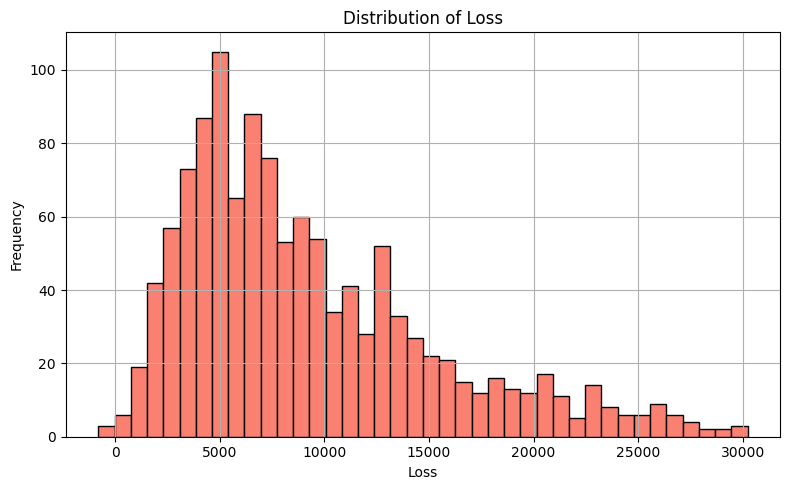

In [10]:
#Import library
import matplotlib.pyplot as plt

#Histogram of 'loss'
plt.figure(figsize=(8, 5))
plt.hist(y, bins=40, color='salmon', edgecolor='black')
plt.title('Distribution of Loss')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

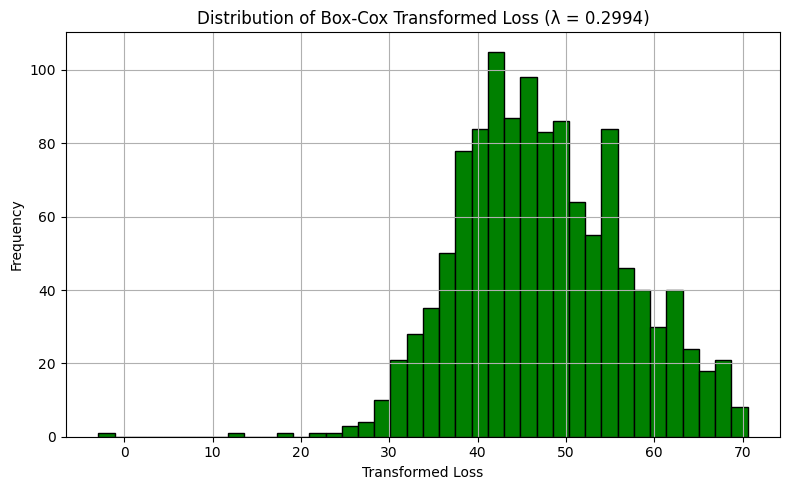

Box-Cox λ: 0.29937965282296036
Shift applied to loss: 807.4909999999998


In [11]:
#Import library
from scipy.stats import boxcox

#Copy y (loss) and check for non-positive values
shift = 0
if y.min() <= 0:
    shift = abs(y.min()) + 1e-3
    y_shifted = y + shift
else:
    y_shifted = y.copy()

#Apply Box-Cox transformation
y_boxcox, fitted_lambda = boxcox(y_shifted)

#Visualize the transformed distribution
plt.figure(figsize=(8,5))
plt.hist(y_boxcox, bins=40, color='green', edgecolor='black')
plt.title(f'Distribution of Box-Cox Transformed Loss (λ = {round(fitted_lambda, 4)})')
plt.xlabel('Transformed Loss')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Box-Cox λ:", fitted_lambda)
print("Shift applied to loss:", shift)

In [12]:
#Select numeric columns
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns

#Calculate correlation matrix for numeric columns
corr_matrix = X[numeric_cols].corr()

#Round correlations to 2 decimals
corr_rounded = corr_matrix.round(2)

print("Correlation matrix (numeric features):")
print(corr_rounded)

Correlation matrix (numeric features):
                      int_rate  installment  annual_inc  revol_bal  \
int_rate                  1.00         0.10       -0.15      -0.04   
installment               0.10         1.00        0.51       0.40   
annual_inc               -0.15         0.51        1.00       0.45   
revol_bal                -0.04         0.40        0.45       1.00   
revol_util                0.15         0.17        0.11       0.23   
total_acc                -0.13         0.22        0.25       0.23   
acc_open_past_24mths      0.20         0.02        0.11      -0.04   

                      revol_util  total_acc  acc_open_past_24mths  
int_rate                    0.15      -0.13                  0.20  
installment                 0.17       0.22                  0.02  
annual_inc                  0.11       0.25                  0.11  
revol_bal                   0.23       0.23                 -0.04  
revol_util                  1.00      -0.09                 

In [13]:
#Drop 'installment' due to correlation
charged_off = charged_off.drop(columns = ['installment'])

#Redefine X after drop
X = charged_off.drop(columns=['loss'])

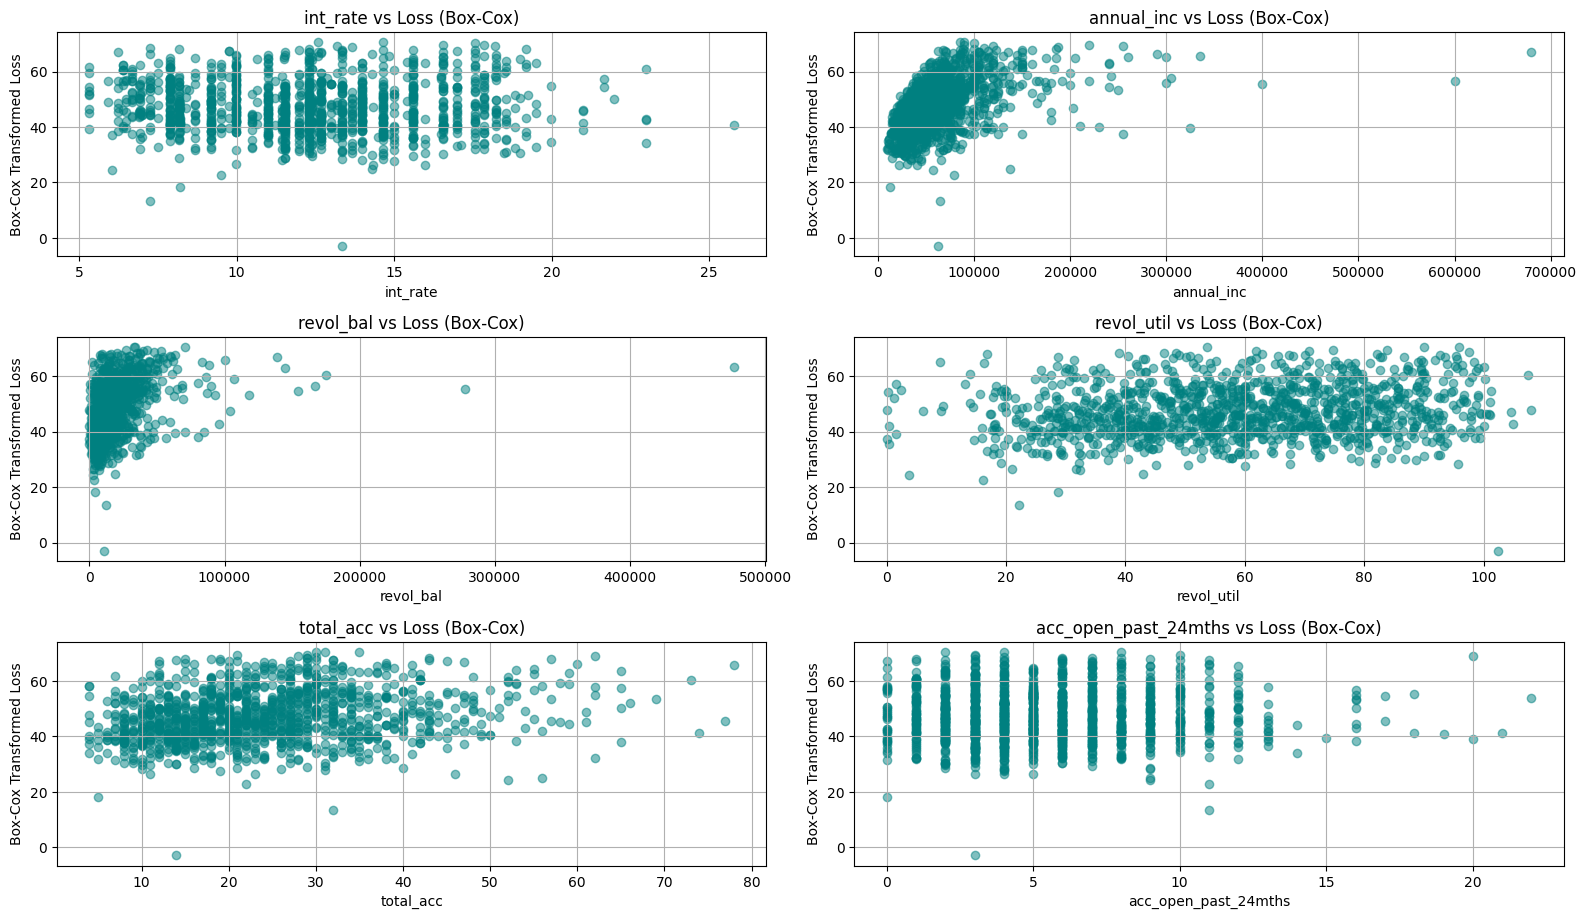

In [14]:
#For each numeric variable, plot a scatterplot against the Box-Cox transformed loss
continuous_vars = X.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(16, len(continuous_vars) * 3))

for i, col in enumerate(continuous_vars, 1):
    plt.subplot(len(continuous_vars), 2, i)
    plt.scatter(X[col], y_boxcox, alpha=0.5, color='teal')
    plt.xlabel(col)
    plt.ylabel('Box-Cox Transformed Loss')
    plt.title(f'{col} vs Loss (Box-Cox)')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
#Import library
from sklearn.model_selection import train_test_split

#Split 60-40
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 12345)

In [16]:
#Import library
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#Initialize and fit
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

#Predict on test set
y_pred = lr_model.predict(X_test)

#Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

#Calculate adjusted R2
n = X_test.shape[0]
p = X_test.shape[1]
r2 = lr_model.score(X_test, y_test)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"Adjusted R-squared: {adj_r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")               

Adjusted R-squared: 0.3166
Root Mean Squared Error (RMSE): 5225.9488


## Part 2 - Regression Tree Model

In [17]:
#Import libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

#Define parameter grid for tuning
param_grid = {'max_depth' : [3,5,7,10,None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Initialize regression tree
reg_tree = DecisionTreeRegressor(random_state=12345)

#Setup GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(reg_tree, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

#Fit GridSearch to training data
grid_search.fit(X_train, y_train)

#Best model from GridSearch
best_tree = grid_search.best_estimator_

#Predict on validation/test data
y_pred = best_tree.predict(X_test)

#Calculate RMSE, MAE and R2
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#Feature importance
importances = pd.Series(best_tree.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("Best hyperparameters:", grid_search.best_params_, "\n")
print(f"RMSE on validation data: {rmse:.4f}", "\n")
print(f"Mean Absolute Error (MAE): {mae:.4f}", "\n")
print(f"R-squared (R2): {r2:.4f}", "\n")
print("Feature importances:")
print(importances)

Best hyperparameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2} 

RMSE on validation data: 5131.6235 

Mean Absolute Error (MAE): 3854.8332 

R-squared (R2): 0.3547 

Feature importances:
annual_inc                             0.650096
revol_bal                              0.233396
verification_status_Verified           0.063237
int_rate                               0.053270
revol_util                             0.000000
total_acc                              0.000000
acc_open_past_24mths                   0.000000
home_ownership_OWN                     0.000000
home_ownership_RENT                    0.000000
verification_status_Source Verified    0.000000
dtype: float64


## Part 2 - Neural Network Model

In [18]:
from sklearn.neural_network import MLPRegressor

#Initialize MLPRegressor
mlp_reg = MLPRegressor(hidden_layer_sizes=(64, 32),
                       max_iter=1000,
                       random_state=12345)

#Fit model on training data
mlp_reg.fit(X_train, y_train)

#Predict on test data
y_pred = mlp_reg.predict(X_test)

#Calculate RMSE, MAE and R2
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE on validation data: {rmse:.4f}")
print(f"MAE on validation data: {mae:.4f}")
print(f"R-squared on validation data: {r2:.4f}")

RMSE on validation data: 5537.7878
MAE on validation data: 3920.2046
R-squared on validation data: 0.2485


In [24]:
#Import warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

#Import library
from sklearn.model_selection import RandomizedSearchCV

#Initialize the base MLPRegressor model
mlp = MLPRegressor(random_state=12345, max_iter=3000, early_stopping = True)

#Define hyperparameter distribution for randomized search
param_dist = {'hidden_layer_sizes': [(50,), (64, 32)],
              'activation': ['relu', 'tanh'],
              'alpha': [0.0001, 0.001, 0.01],
              'learning_rate_init': [0.005, 0.01, 0.05],
              'solver': ['adam']}

# Set up randomized search with 20 iterations and 3-fold cross-validation
random_search = RandomizedSearchCV(mlp,
                                   param_distributions=param_dist,
                                   n_iter=20,
                                   scoring='neg_root_mean_squared_error',
                                   cv=3,
                                   random_state=12345,
                                   n_jobs=-1)

# Fit the model on training data
random_search.fit(X_train, y_train)

# Output the best hyperparameters
print("Best hyperparameters found:", random_search.best_params_)

# Evaluate the best model on validation (test) data
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

Best hyperparameters found: {'solver': 'adam', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (64, 32), 'alpha': 0.0001, 'activation': 'relu'}


/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 5699.0106
MAE: 3985.1076
R-squared: 0.2041
